<a id=top-page></a>

# Illustrative example of performing dimensionality reduction with a regression-aware autoencoder on a synthetic 2D dataset

***

#### Table of contents

- [**Define the regression-aware autoencoders**](#R-A-AE)
    - [A linear-to-linear autoencoder](#AE-l-to-l)
    - [A linear-to-nonlinear autoencoder](#AE-l-to-n)
- [**Generate a synthetic 2D dataset**](#2D-data)
    - [Visualize the 2D dataset and the dependent variables](#2D-data-visualize)
    - [Compute the directions of one-dimensional projections of the 2D dataset](#2D-data-1D-directions)
    - [Visualize the reconstructed dependent variables](#2D-data-reconstructed-phi)
    - [Visualize the reconstructed dependent variables as functions of the single manifold parameter, $\eta_1$](#2D-data-reconstructed-phi-eta)
    - [The effect of reconstructing multiple dependent variables at the output](#2D-data-multiple-output)
    - [Does more training data promote more optimal projections?](#2D-data-increasing-N)

***

In [3]:
%run -i imports.py
%matplotlib inline

In [4]:
plot_save_location = '../figures/'

<a id=R-A-AE></a>
***

## Define the regression-aware autoencoders

[Go to the top ↑](#top-page)

<a id=AE-l-to-l></a>

### A linear-to-linear autoencoder

[Go to the top ↑](#top-page)

In [5]:
def autoencoder_linear_to_linear(X_input, X_output, n_dim, n_epochs=None, train_perc=80, learning_rate=0.001, batch_size=10, verbose=False):

    tic = time.perf_counter()
    
    (n_observations, n_variables_input) = np.shape(X_input)
    (_, n_variables_output) = np.shape(X_output)

    sample_random = preprocess.DataSampler(np.zeros((n_observations,)).astype(int), random_seed=100, verbose=False)
    (idx_train, idx_test) = sample_random.random(train_perc)

    tf.random.set_seed(random_seed)

    input_X = keras.Input(shape=(n_variables_input,))
    manifold_layer = layers.Dense(n_dim, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='zeros')(input_X)
    decoded = layers.Dense(n_variables_output, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='zeros')(manifold_layer)

    autoencoder = keras.Model(input_X, decoded)
    autoencoder.compile(tf.optimizers.Adam(learning_rate), loss=tf.keras.losses.MeanSquaredError())

    weights_and_biases = autoencoder.get_weights()

    if n_epochs is None:
        
        if verbose: print('\nEarly stopping is used.\n')
        
        monitor = EarlyStopping(monitor='loss',
                    min_delta=1e-6,
                    patience=100,
                    verbose=0,
                    mode='auto',
                    restore_best_weights=True)
            
        history = autoencoder.fit(X_input[idx_train,:], X_output[idx_train,:],
                    epochs=1000,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_input[idx_test,:], X_output[idx_test,:]),
                    callbacks=[monitor],
                    verbose=0)
    else:
        
        history = autoencoder.fit(X_input[idx_train,:], X_output[idx_train,:],
                    epochs=n_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_input[idx_test,:], X_output[idx_test,:]),
                    verbose=0)
    
    n_epochs = len(history.history['loss'])
    if verbose: print('AE was run with ' + str(n_epochs) + ' epochs.')
    
    encoder_1 = keras.Model(input_X, manifold_layer)
    projection_1 = encoder_1.predict(X_input)
    
    encoder_4 = keras.Model(input_X, decoded)
    projection_4 = encoder_4.predict(X_input)

    projection_1_basis = encoder_1.get_weights()[0]
    projection_1_basis = projection_1_basis / np.linalg.norm(projection_1_basis, axis=0)
    
    autoencoder.set_weights(weights_and_biases)

    final_loss = history.history['val_loss'][-1]
    
    if verbose: print('Final loss: ' + str(round(final_loss, 10)))
    
    toc = time.perf_counter()

    if verbose: print(f'Time it took for this run: {(toc - tic)/60:0.1f} minutes.\n' + '- '*22)

    return history, projection_1, projection_4, projection_1_basis, final_loss

<a id=AE-l-to-n></a>

### A linear-to-nonlinear autoencoder

[Go to the top ↑](#top-page)

In [6]:
def autoencoder_linear_to_nonlinear(X_input, X_output, n_dim, c, d, n_epochs=None, train_perc=80, learning_rate=0.001, batch_size=10, verbose=False):

    tic = time.perf_counter()
    
    (n_observations, n_variables_input) = np.shape(X_input)
    (_, n_variables_output) = np.shape(X_output)

    sample_random = preprocess.DataSampler(np.zeros((n_observations,)).astype(int), random_seed=100, verbose=False)
    (idx_train, idx_test) = sample_random.random(train_perc)

    tf.random.set_seed(random_seed)

    input_X = keras.Input(shape=(n_variables_input,))
    manifold_layer = layers.Dense(n_dim, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='zeros')(input_X)
    decoded_1 = layers.Dense(c, activation='tanh', kernel_initializer='glorot_uniform', bias_initializer='zeros')(manifold_layer)
    decoded_2 = layers.Dense(d, activation='tanh', kernel_initializer='glorot_uniform', bias_initializer='zeros')(decoded_1)
    decoded = layers.Dense(n_variables_output, activation='tanh', kernel_initializer='glorot_uniform', bias_initializer='zeros')(decoded_2)

    autoencoder = keras.Model(input_X, decoded)
    autoencoder.compile(tf.optimizers.Adam(learning_rate), loss=tf.keras.losses.MeanSquaredError())

    weights_and_biases = autoencoder.get_weights()

    if n_epochs is None:
        
        if verbose: print('\nEarly stopping is used.\n')
        
        monitor = EarlyStopping(monitor='loss',
                    min_delta=1e-6,
                    patience=100,
                    verbose=0,
                    mode='auto',
                    restore_best_weights=True)
            
        history = autoencoder.fit(X_input[idx_train,:], X_output[idx_train,:],
                    epochs=1000,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_input[idx_test,:], X_output[idx_test,:]),
                    callbacks=[monitor],
                    verbose=0)
    else:
        
        history = autoencoder.fit(X_input[idx_train,:], X_output[idx_train,:],
                    epochs=n_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_input[idx_test,:], X_output[idx_test,:]),
                    verbose=0)
    
    n_epochs = len(history.history['loss'])
    if verbose: print('AE was run with ' + str(n_epochs) + ' epochs.')
    
    encoder_1 = keras.Model(input_X, manifold_layer)
    projection_1 = encoder_1.predict(X_input)
    
    encoder_2 = keras.Model(input_X, decoded_1)
    projection_2 = encoder_2.predict(X_input)

    encoder_3 = keras.Model(input_X, decoded_2)
    projection_3 = encoder_3.predict(X_input)
    
    encoder_4 = keras.Model(input_X, decoded)
    projection_4 = encoder_4.predict(X_input)

    projection_1_basis = encoder_1.get_weights()[0]
    projection_1_basis = projection_1_basis / np.linalg.norm(projection_1_basis, axis=0)
    
    autoencoder.set_weights(weights_and_biases)

    final_loss = history.history['val_loss'][-1]
    
    if verbose: print('Final loss: ' + str(round(final_loss, 10)))
    
    toc = time.perf_counter()

    if verbose: print(f'Time it took for this run: {(toc - tic)/60:0.1f} minutes.\n' + '- '*22)

    return history, projection_1, projection_2, projection_3, projection_4, projection_1_basis, final_loss

<a id=2D-data></a>
***

## Generate a synthetic 2D dataset

[Go to the top ↑](#top-page)

In [7]:
n_points = 2000
np.random.seed(seed=10)
mean = [0,0]
covariance = [[2, 0.52], [0.52, 0.2]]
x_noise, y_noise = np.random.multivariate_normal(mean, covariance, n_points).T
dataset_2D = np.column_stack((x_noise, y_noise))
dataset_2D_normalized, centers_2D, scales_2D = preprocess.center_scale(dataset_2D, scaling='-1to1')

phi_1 = np.sin((dataset_2D_normalized[:,0]+0.8))
phi_2 = np.sin((dataset_2D_normalized[:,1]+0.8))
phi_3 = np.sin(dataset_2D_normalized[:,0]*3) + np.abs(dataset_2D_normalized[:,1])
phi_4 = np.exp(-((np.sqrt(dataset_2D_normalized[:,0]**2+dataset_2D_normalized[:,1]**2))**2 / (2.0 * 0.3**2)))

phi_2D = np.column_stack((phi_1, phi_2, phi_3, phi_4))
phi_2D_normalized, centers_phi, scales_phi = preprocess.center_scale(phi_2D, scaling='-1to1')

<a id=2D-data-visualize></a>

### Visualize the 2D dataset and the dependent variables

[Go to the top ↑](#top-page)

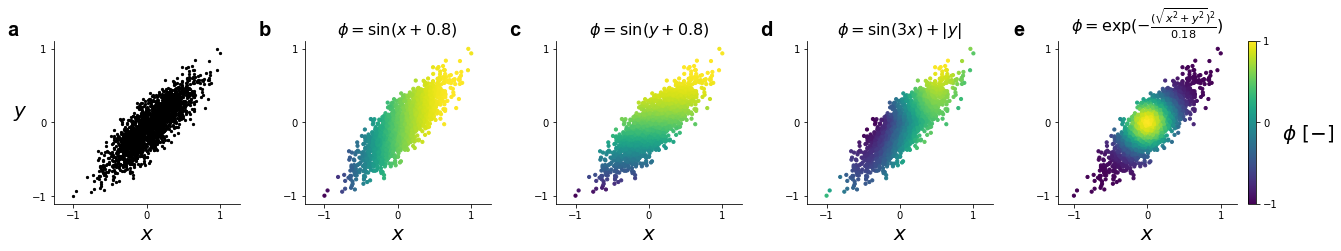

In [8]:
fig = plt.figure(figsize=(22, 3))
spec = fig.add_gridspec(ncols=9, nrows=1, width_ratios=[1,0.1,1,0.1,1,0.1,1,0.1,1.2], height_ratios=[1])

point_size = 10

figure_a = fig.add_subplot(spec[0,0])
plt.scatter(dataset_2D_normalized[:,0],
            dataset_2D_normalized[:,1],
            s=5,
            c='k')
plt.axis('equal');
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$y$', fontsize=20, rotation=0, horizontalalignment='right')
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'a', fontsize=20, transform=figure_a.transAxes, **hfont)


figure_b = fig.add_subplot(spec[0,2])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=phi_2D_normalized[:,0])
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'b', fontsize=20, transform=figure_b.transAxes, **hfont)
plt.title('$\phi = \sin(x+0.8)$', fontsize=16)

figure_c = fig.add_subplot(spec[0,4])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=phi_2D_normalized[:,1])
plt.axis('equal');
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'c', fontsize=20, transform=figure_c.transAxes, **hfont)
plt.title('$\phi = \sin(y+0.8)$', fontsize=16)

figure_d = fig.add_subplot(spec[0,6])
scat = plt.scatter(dataset_2D_normalized[:,0], 
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=phi_2D_normalized[:,2])
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'd', fontsize=20, transform=figure_d.transAxes, **hfont)
plt.title(r'$\phi = \sin (3x) + |y|$', fontsize=16)

figure_e = fig.add_subplot(spec[0,8])
scat = plt.scatter(dataset_2D_normalized[:,0], 
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=phi_2D_normalized[:,3])
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'e', fontsize=20, transform=figure_e.transAxes, **hfont)
plt.title(r'$\phi = \exp (- \frac{(\sqrt{x^2 + y^2})^2}{0.18} )$', fontsize=16)
cbar = plt.colorbar(scat, ticks=[-1,0,1])
cbar.set_label('$\phi$ [$-$]', fontsize=20, rotation=0, horizontalalignment='left')
for t in cbar.ax.get_xticklabels():
     t.set_fontsize(16)
        
plt.savefig(plot_save_location + 'AE-synthetic-2D-data.png', dpi=200, bbox_inches='tight')

<a id=2D-data-1D-directions></a>

### Compute the directions of one-dimensional projections of the 2D dataset

[Go to the top ↑](#top-page)

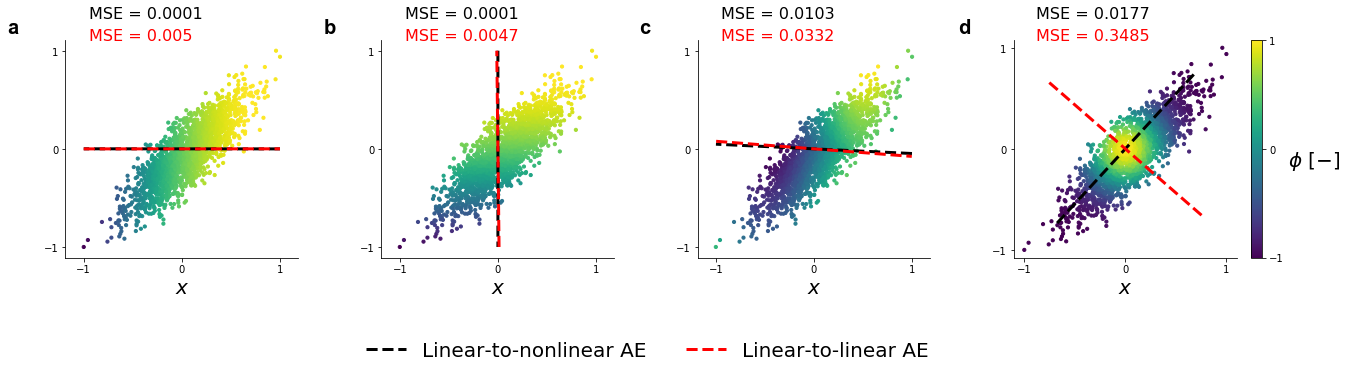

In [9]:
fig = plt.figure(figsize=(22, 4))
spec = fig.add_gridspec(ncols=7, nrows=1, width_ratios=[1,0.1,1,0.1,1,0.1,1.2], height_ratios=[1])

point_size = 10

# Phi 1: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
_, _, _, _, _, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,0:1],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, _, _, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,0:1],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

figure_b = fig.add_subplot(spec[0,0])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=phi_2D_normalized[:,0])
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'a', fontsize=20, transform=figure_b.transAxes, **hfont)
plt.plot([-basis_tanh[0,0], basis_tanh[0,0]], [-basis_tanh[1,0], basis_tanh[1,0]], 'k--', lw=3, label='Direction of 1D projection with $f$ = tanh')
plt.plot([-basis_linear[0,0], basis_linear[0,0]], [-basis_linear[1,0], basis_linear[1,0]], 'r--', lw=3, label='Direction of 1D projection with $f$ = linear')
plt.text(0.1,1.1, 'MSE = ' + str(round(final_loss_tanh,4)), fontsize=16, color='k', transform=figure_b.transAxes)
plt.text(0.1,1, 'MSE = ' + str(round(final_loss_linear,4)), fontsize=16, color='r', transform=figure_b.transAxes)

# Phi 2: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
_, _, _, _, _, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,1:2],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, _, _, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,1:2],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

figure_c = fig.add_subplot(spec[0,2])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=phi_2D_normalized[:,1])
plt.axis('equal');
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'b', fontsize=20, transform=figure_c.transAxes, **hfont)
plt.plot([-basis_tanh[0,0], basis_tanh[0,0]], [-basis_tanh[1,0], basis_tanh[1,0]], 'k--', lw=3, label='Direction of 1D projection with $f$ = tanh')
plt.plot([-basis_linear[0,0], basis_linear[0,0]], [-basis_linear[1,0], basis_linear[1,0]], 'r--', lw=3, label='Direction of 1D projection with $f$ = linear')
plt.text(0.1,1.1, 'MSE = ' + str(round(final_loss_tanh,4)), fontsize=16, color='k', transform=figure_c.transAxes)
plt.text(0.1,1, 'MSE = ' + str(round(final_loss_linear,4)), fontsize=16, color='r', transform=figure_c.transAxes)

# Phi 3: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
_, _, _, _, _, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,2:3],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, _, _, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,2:3],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)
    
figure_d = fig.add_subplot(spec[0,4])
scat = plt.scatter(dataset_2D_normalized[:,0], 
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=phi_2D_normalized[:,2])
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'c', fontsize=20, transform=figure_d.transAxes, **hfont)
plt.plot([-basis_tanh[0,0], basis_tanh[0,0]], [-basis_tanh[1,0], basis_tanh[1,0]], 'k--', lw=3, label='Direction of 1D projection with $f$ = tanh')
plt.plot([-basis_linear[0,0], basis_linear[0,0]], [-basis_linear[1,0], basis_linear[1,0]], 'r--', lw=3, label='Direction of 1D projection with $f$ = linear')
plt.text(0.1,1.1, 'MSE = ' + str(round(final_loss_tanh,4)), fontsize=16, color='k', transform=figure_d.transAxes)
plt.text(0.1,1, 'MSE = ' + str(round(final_loss_linear,4)), fontsize=16, color='r', transform=figure_d.transAxes)

# Phi 4: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
_, _, _, _, _, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,3:4],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, _, _, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,3:4],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

figure_e = fig.add_subplot(spec[0,6])
scat = plt.scatter(dataset_2D_normalized[:,0], 
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=phi_2D_normalized[:,3])
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'd', fontsize=20, transform=figure_e.transAxes, **hfont)
plt.plot([-basis_tanh[0,0], basis_tanh[0,0]], [-basis_tanh[1,0], basis_tanh[1,0]], 'k--', lw=3, label='Linear-to-nonlinear AE')
plt.plot([-basis_linear[0,0], basis_linear[0,0]], [-basis_linear[1,0], basis_linear[1,0]], 'r--', lw=3, label='Linear-to-linear AE')
plt.legend(ncol=2, frameon=False, bbox_to_anchor=(-0.3,-0.3), fontsize=20)
plt.text(0.1,1.1, 'MSE = ' + str(round(final_loss_tanh,4)), fontsize=16, color='k', transform=figure_e.transAxes)
plt.text(0.1,1, 'MSE = ' + str(round(final_loss_linear,4)), fontsize=16, color='r', transform=figure_e.transAxes)

cbar = plt.colorbar(scat, ticks=[-1,0,1])
cbar.set_label('$\phi$ [$-$]', fontsize=20, rotation=0, horizontalalignment='left')
for t in cbar.ax.get_xticklabels():
     t.set_fontsize(16)
        
plt.savefig(plot_save_location + 'AE-synthetic-2D-data-compressed.png', dpi=200, bbox_inches='tight')

<a id=2D-data-reconstructed-phi></a>

### Visualize the reconstructed dependent variables

[Go to the top ↑](#top-page)

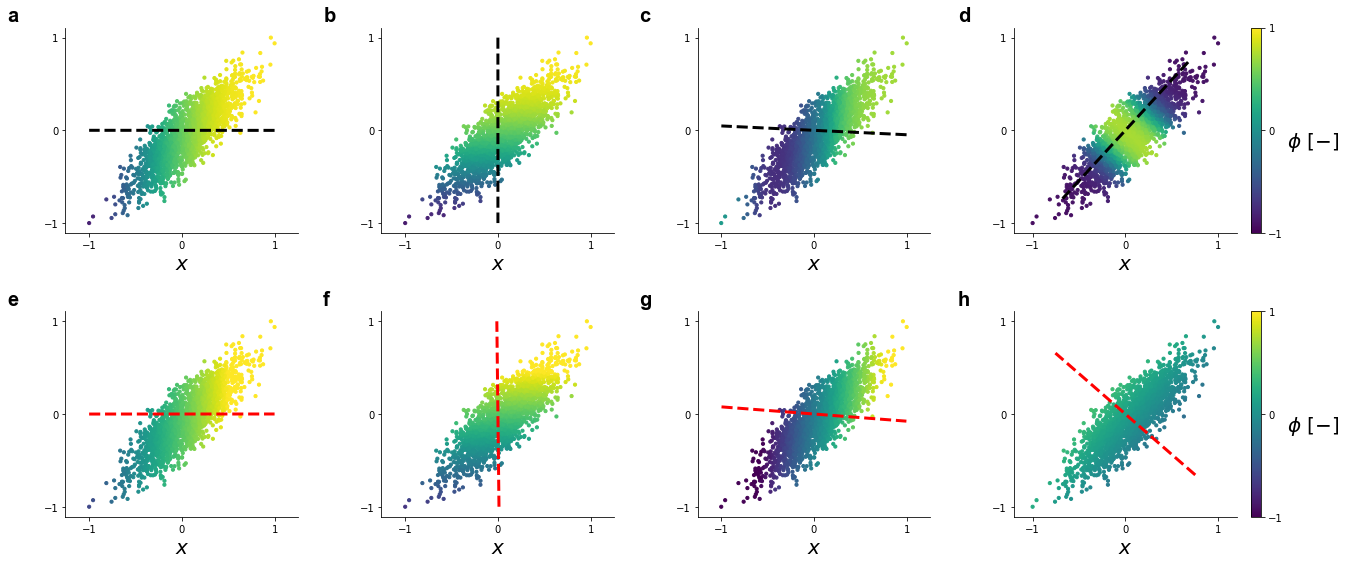

In [10]:
fig = plt.figure(figsize=(22, 9))
spec = fig.add_gridspec(ncols=7, nrows=3, width_ratios=[1,0.1,1,0.1,1,0.1,1.2], height_ratios=[1,0.1,1])

point_size = 10

# Phi 1: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
_, _, _, _, reconstruction_tanh, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,0:1],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, _, reconstruction_linear, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,0:1],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

figure_b = fig.add_subplot(spec[0,0])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=reconstruction_tanh.ravel(), vmin=-1, vmax=1)
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'a', fontsize=20, transform=figure_b.transAxes, **hfont)
plt.plot([-basis_tanh[0,0], basis_tanh[0,0]], [-basis_tanh[1,0], basis_tanh[1,0]], 'k--', lw=3, label='Direction of 1D projection with $f$ = tanh')

figure_b = fig.add_subplot(spec[2,0])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=reconstruction_linear.ravel(), vmin=-1, vmax=1)
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'e', fontsize=20, transform=figure_b.transAxes, **hfont)
plt.plot([-basis_linear[0,0], basis_linear[0,0]], [-basis_linear[1,0], basis_linear[1,0]], 'r--', lw=3, label='Direction of 1D projection with $f$ = linear')

# Phi 2: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
_, _, _, _, reconstruction_tanh, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,1:2],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, _, reconstruction_linear, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,1:2],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

figure_c = fig.add_subplot(spec[0,2])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=reconstruction_tanh.ravel(), vmin=-1, vmax=1)
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'b', fontsize=20, transform=figure_c.transAxes, **hfont)
plt.plot([-basis_tanh[0,0], basis_tanh[0,0]], [-basis_tanh[1,0], basis_tanh[1,0]], 'k--', lw=3, label='Direction of 1D projection with $f$ = tanh')

figure_c = fig.add_subplot(spec[2,2])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=reconstruction_linear.ravel(), vmin=-1, vmax=1)
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'f', fontsize=20, transform=figure_c.transAxes, **hfont)
plt.plot([-basis_linear[0,0], basis_linear[0,0]], [-basis_linear[1,0], basis_linear[1,0]], 'r--', lw=3, label='Direction of 1D projection with $f$ = linear')

# Phi 3: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
_, _, _, _, reconstruction_tanh, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,2:3],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, _, reconstruction_linear, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,2:3],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)
    
figure_d = fig.add_subplot(spec[0,4])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=reconstruction_tanh.ravel(), vmin=-1, vmax=1)
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'c', fontsize=20, transform=figure_d.transAxes, **hfont)
plt.plot([-basis_tanh[0,0], basis_tanh[0,0]], [-basis_tanh[1,0], basis_tanh[1,0]], 'k--', lw=3, label='Direction of 1D projection with $f$ = tanh')

figure_d = fig.add_subplot(spec[2,4])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=reconstruction_linear.ravel(), vmin=-1, vmax=1)
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'g', fontsize=20, transform=figure_d.transAxes, **hfont)
plt.plot([-basis_linear[0,0], basis_linear[0,0]], [-basis_linear[1,0], basis_linear[1,0]], 'r--', lw=3, label='Direction of 1D projection with $f$ = linear')

# Phi 4: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
_, _, _, _, reconstruction_tanh, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,3:4],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, _, reconstruction_linear, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,3:4],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

figure_e = fig.add_subplot(spec[0,6])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=reconstruction_tanh.ravel(), vmin=-1, vmax=1)
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'd', fontsize=20, transform=figure_e.transAxes, **hfont)
plt.plot([-basis_tanh[0,0], basis_tanh[0,0]], [-basis_tanh[1,0], basis_tanh[1,0]], 'k--', lw=3, label='Direction of 1D projection with $f$ = tanh')

cbar = plt.colorbar(scat, ticks=[-1,0,1])
cbar.set_label('$\phi$ [$-$]', fontsize=20, rotation=0, horizontalalignment='left')
for t in cbar.ax.get_xticklabels():
     t.set_fontsize(16)
        
figure_e = fig.add_subplot(spec[2,6])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c=reconstruction_linear.ravel(), vmin=-1, vmax=1)
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'h', fontsize=20, transform=figure_e.transAxes, **hfont)
plt.plot([-basis_linear[0,0], basis_linear[0,0]], [-basis_linear[1,0], basis_linear[1,0]], 'r--', lw=3, label='Direction of 1D projection with $f$ = linear')

cbar = plt.colorbar(scat, ticks=[-1,0,1])
cbar.set_label('$\phi$ [$-$]', fontsize=20, rotation=0, horizontalalignment='left')
for t in cbar.ax.get_xticklabels():
     t.set_fontsize(16)
        
plt.savefig(plot_save_location + 'AE-synthetic-2D-data-reconstructed.png', dpi=200, bbox_inches='tight')

<a id=2D-data-reconstructed-phi-eta></a>

### Visualize the reconstructed dependent variables as functions of the single manifold parameter, $\eta_1$

[Go to the top ↑](#top-page)

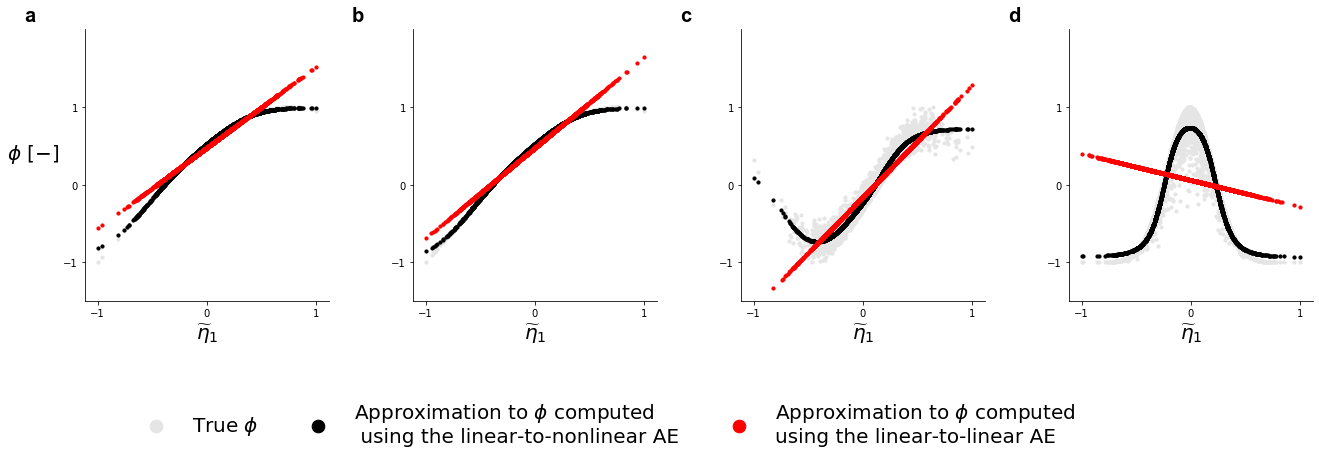

In [8]:
fig = plt.figure(figsize=(22, 5))
spec = fig.add_gridspec(ncols=7, nrows=1, width_ratios=[1,0.1,1,0.1,1,0.1,1], height_ratios=[1])

point_size = 10

# Phi 1: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
_, projection_tanh, _, _, reconstruction_tanh, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,0:1],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, projection_linear, reconstruction_linear, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,0:1],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

projection_tanh_normalized, _, _ = preprocess.center_scale(projection_tanh, scaling='-1to1')
projection_linear_normalized, _, _ = preprocess.center_scale(projection_linear, scaling='-1to1')

figure_a = fig.add_subplot(spec[0,0])
plt.scatter(-projection_tanh_normalized[:,0], reconstruction_tanh[:,0], c='k', s=point_size, zorder=10)
plt.scatter(-projection_tanh_normalized[:,0], phi_2D_normalized[:,0:1], c='#e5e5e5', s=point_size, zorder=1)
plt.scatter(projection_linear_normalized[:,0], reconstruction_linear[:,0], c='r', s=point_size, zorder=20)
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.ylim([-1.5,2])
plt.xlabel('$\widetilde{\eta}_1$', fontsize=20)
plt.ylabel('$\phi$ [$-$]', fontsize=20, rotation=0, horizontalalignment='right')
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'a', fontsize=20, transform=figure_a.transAxes, **hfont)

# Phi 2: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
_, projection_tanh, _, _, reconstruction_tanh, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,1:2],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, projection_linear, reconstruction_linear, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,1:2],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

projection_tanh_normalized, _, _ = preprocess.center_scale(projection_tanh, scaling='-1to1')
projection_linear_normalized, _, _ = preprocess.center_scale(projection_linear, scaling='-1to1')

figure_b = fig.add_subplot(spec[0,2])
plt.scatter(-projection_tanh_normalized[:,0], reconstruction_tanh[:,0], c='k', s=point_size, zorder=10)
plt.scatter(-projection_tanh_normalized[:,0], phi_2D_normalized[:,1:2], c='#e5e5e5', s=point_size, zorder=1)
plt.scatter(projection_linear_normalized[:,0], reconstruction_linear[:,0], c='r', s=point_size, zorder=20)
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.ylim([-1.5,2])
plt.xlabel('$\widetilde{\eta}_1$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'b', fontsize=20, transform=figure_b.transAxes, **hfont)

# Phi 3: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
_, projection_tanh, _, _, reconstruction_tanh, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,2:3],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, projection_linear, reconstruction_linear, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,2:3],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

projection_tanh_normalized, _, _ = preprocess.center_scale(projection_tanh, scaling='-1to1')
projection_linear_normalized, _, _ = preprocess.center_scale(projection_linear, scaling='-1to1')

figure_c = fig.add_subplot(spec[0,4])
plt.scatter(-projection_tanh_normalized[:,0], reconstruction_tanh[:,0], c='k', s=point_size, zorder=10)
plt.scatter(-projection_tanh_normalized[:,0], phi_2D_normalized[:,2:3], c='#e5e5e5', s=point_size, zorder=1)
plt.scatter(projection_linear_normalized[:,0], reconstruction_linear[:,0], c='r', s=point_size, zorder=20)
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.ylim([-1.5,2])
plt.xlabel('$\widetilde{\eta}_1$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'c', fontsize=20, transform=figure_c.transAxes, **hfont)

# Phi 4: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
_, projection_tanh, _, _, reconstruction_tanh, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,3:4],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, projection_linear, reconstruction_linear, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,3:4],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

projection_tanh_normalized, _, _ = preprocess.center_scale(projection_tanh, scaling='-1to1')
projection_linear_normalized, _, _ = preprocess.center_scale(projection_linear, scaling='-1to1')

figure_d = fig.add_subplot(spec[0,6])
plt.scatter(projection_tanh_normalized[:,0], phi_2D_normalized[:,3:4], c='#e5e5e5', s=point_size, zorder=1, label='True $\phi$')
plt.scatter(projection_tanh_normalized[:,0], reconstruction_tanh[:,0], c='k', s=point_size, zorder=10, label='Approximation to $\phi$ computed\n using the linear-to-nonlinear AE')
plt.scatter(-projection_linear_normalized[:,0], reconstruction_linear[:,0], c='r', s=point_size, zorder=20, label='Approximation to $\phi$ computed\nusing the linear-to-linear AE')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.ylim([-1.5,2])
plt.xlabel('$\widetilde{\eta}_1$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'd', fontsize=20, transform=figure_d.transAxes, **hfont)
plt.legend(ncol=3, frameon=False, bbox_to_anchor=(0.1,-0.3), fontsize=20, markerscale=4)

plt.savefig(plot_save_location + 'AE-synthetic-2D-data-reconstructed-lines.png', dpi=200, bbox_inches='tight')

<a id=2D-data-multiple-output></a>

### The effect of reconstructing multiple dependent variables at the output

[Go to the top ↑](#top-page)

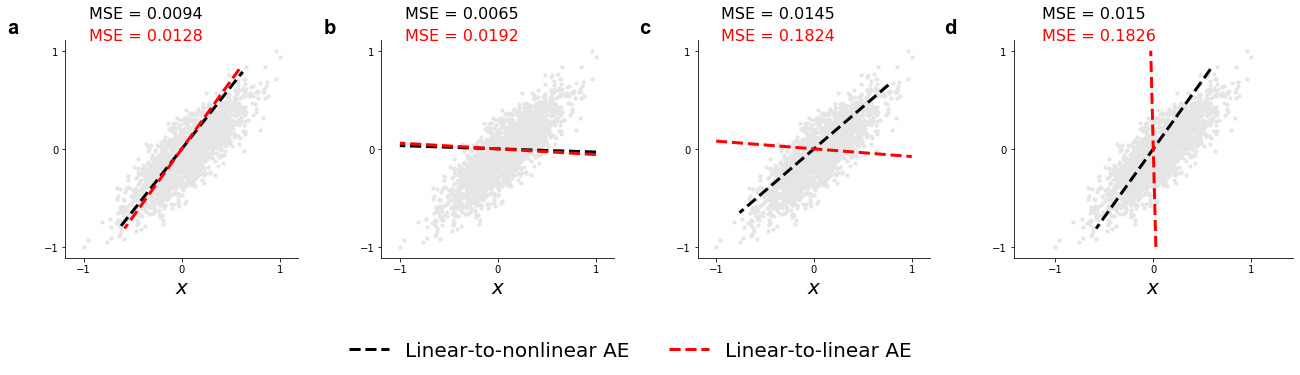

In [12]:
fig = plt.figure(figsize=(22, 4))
spec = fig.add_gridspec(ncols=7, nrows=1, width_ratios=[1,0.1,1,0.1,1,0.1,1.2], height_ratios=[1])

point_size = 10

# Phi 1: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
_, _, _, _, _, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,0:2],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, _, _, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,0:2],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

figure_b = fig.add_subplot(spec[0,0])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c='#e5e5e5')
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'a', fontsize=20, transform=figure_b.transAxes, **hfont)
plt.plot([-basis_tanh[0,0], basis_tanh[0,0]], [-basis_tanh[1,0], basis_tanh[1,0]], 'k--', lw=3, label='Direction of 1D projection with $f$ = tanh')
plt.plot([-basis_linear[0,0], basis_linear[0,0]], [-basis_linear[1,0], basis_linear[1,0]], 'r--', lw=3, label='Direction of 1D projection with $f$ = linear')
plt.text(0.1,1.1, 'MSE = ' + str(round(final_loss_tanh,4)), fontsize=16, color='k', transform=figure_b.transAxes)
plt.text(0.1,1, 'MSE = ' + str(round(final_loss_linear,4)), fontsize=16, color='r', transform=figure_b.transAxes)

# Phi 2: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
_, _, _, _, _, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,[0,2]],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, _, _, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,[0,2]],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

figure_c = fig.add_subplot(spec[0,2])
scat = plt.scatter(dataset_2D_normalized[:,0],
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c='#e5e5e5')
plt.axis('equal');
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'b', fontsize=20, transform=figure_c.transAxes, **hfont)
plt.plot([-basis_tanh[0,0], basis_tanh[0,0]], [-basis_tanh[1,0], basis_tanh[1,0]], 'k--', lw=3, label='Direction of 1D projection with $f$ = tanh')
plt.plot([-basis_linear[0,0], basis_linear[0,0]], [-basis_linear[1,0], basis_linear[1,0]], 'r--', lw=3, label='Direction of 1D projection with $f$ = linear')
plt.text(0.1,1.1, 'MSE = ' + str(round(final_loss_tanh,4)), fontsize=16, color='k', transform=figure_c.transAxes)
plt.text(0.1,1, 'MSE = ' + str(round(final_loss_linear,4)), fontsize=16, color='r', transform=figure_c.transAxes)

# Phi 3: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
_, _, _, _, _, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,[0,3]],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, _, _, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,[0,3]],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)
    
figure_d = fig.add_subplot(spec[0,4])
scat = plt.scatter(dataset_2D_normalized[:,0], 
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c='#e5e5e5')
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'c', fontsize=20, transform=figure_d.transAxes, **hfont)
plt.plot([-basis_tanh[0,0], basis_tanh[0,0]], [-basis_tanh[1,0], basis_tanh[1,0]], 'k--', lw=3, label='Direction of 1D projection with $f$ = tanh')
plt.plot([-basis_linear[0,0], basis_linear[0,0]], [-basis_linear[1,0], basis_linear[1,0]], 'r--', lw=3, label='Direction of 1D projection with $f$ = linear')
plt.text(0.1,1.1, 'MSE = ' + str(round(final_loss_tanh,4)), fontsize=16, color='k', transform=figure_d.transAxes)
plt.text(0.1,1, 'MSE = ' + str(round(final_loss_linear,4)), fontsize=16, color='r', transform=figure_d.transAxes)

# Phi 4: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
_, _, _, _, _, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                         phi_2D_normalized[:,[1,3]],
                                         n_dim=1,
                                         c=2,
                                         d=2,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

_, _, _, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                         phi_2D_normalized[:,[1,3]],
                                         n_dim=1,
                                         n_epochs=None,
                                         train_perc=80,
                                         learning_rate=0.001,
                                         batch_size=100)

figure_e = fig.add_subplot(spec[0,6])
scat = plt.scatter(dataset_2D_normalized[:,0], 
                   dataset_2D_normalized[:,1],
                   s=point_size,
                   c='#e5e5e5')
plt.axis('equal')
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('$x$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.25,1.03, 'd', fontsize=20, transform=figure_e.transAxes, **hfont)
plt.plot([-basis_tanh[0,0], basis_tanh[0,0]], [-basis_tanh[1,0], basis_tanh[1,0]], 'k--', lw=3, label='Linear-to-nonlinear AE')
plt.plot([-basis_linear[0,0], basis_linear[0,0]], [-basis_linear[1,0], basis_linear[1,0]], 'r--', lw=3, label='Linear-to-linear AE')
plt.legend(ncol=2, frameon=False, bbox_to_anchor=(-0.3,-0.3), fontsize=20)
plt.text(0.1,1.1, 'MSE = ' + str(round(final_loss_tanh,4)), fontsize=16, color='k', transform=figure_e.transAxes)
plt.text(0.1,1, 'MSE = ' + str(round(final_loss_linear,4)), fontsize=16, color='r', transform=figure_e.transAxes)

plt.savefig(plot_save_location + 'AE-synthetic-2D-data-compressed-multiple-outputs.png', dpi=200, bbox_inches='tight')

<a id=2D-data-increasing-N></a>

### Does more training data promote more optimal projections?

[Go to the top ↑](#top-page)

In [18]:
n_points_list = [100,500] + [1000*i for i in range(1,16)]

In [19]:
mse_tanh = []
mse_linear = []
dot_product_tanh = []
dot_product_linear = []

tic = time.perf_counter()

for n_points in n_points_list:

    print('Running for ' + str(n_points) + ' observations in the training data.')
    
    np.random.seed(seed=10)
    mean = [0,0]
    covariance = [[2, 0.52], [0.52, 0.2]]
    x_noise, y_noise = np.random.multivariate_normal(mean, covariance, n_points).T
    dataset_2D = np.column_stack((x_noise, y_noise))
    dataset_2D_normalized, centers_2D, scales_2D = preprocess.center_scale(dataset_2D, scaling='-1to1')

    phi_1 = np.sin((dataset_2D_normalized[:,0]+0.8))
    phi_2 = np.sin((dataset_2D_normalized[:,1]+0.8))
    phi_3 = np.sin(dataset_2D_normalized[:,0] * 8)
    phi_4 = np.exp(-((np.sqrt(dataset_2D_normalized[:,0]**2+dataset_2D_normalized[:,1]**2))**2 / (2.0 * 0.3**2)))

    phi_2D = np.column_stack((phi_1, phi_2, phi_3, phi_4))
    phi_2D_normalized, centers_phi, scales_phi = preprocess.center_scale(phi_2D, scaling='-1to1')
    
    _, _, _, _, _, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                             phi_2D_normalized[:,0:1],
                                             n_dim=1,
                                             c=2,
                                             d=2,
                                             n_epochs=None,
                                             train_perc=80,
                                             learning_rate=0.001,
                                             batch_size=100)

    _, _, _, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                             phi_2D_normalized[:,0:1],
                                             n_dim=1,
                                             n_epochs=None,
                                             train_perc=80,
                                             learning_rate=0.001,
                                             batch_size=100)
    
    mse_tanh.append(final_loss_tanh)
    mse_linear.append(final_loss_linear)
    dot_product_tanh.append(np.abs(np.dot(basis_tanh.T, np.array([[1],[0]]))[0,0]))
    dot_product_linear.append(np.abs(np.dot(basis_linear.T, np.array([[1],[0]]))[0,0]))

np.savetxt('../results/2D-synthetic-dataset-effect-of-N-phi-1-dot-product-tanh.csv', (dot_product_tanh), delimiter=',', fmt='%.16e')
np.savetxt('../results/2D-synthetic-dataset-effect-of-N-phi-1-dot-product-linear.csv', (dot_product_linear), delimiter=',', fmt='%.16e')
np.savetxt('../results/2D-synthetic-dataset-effect-of-N-phi-1-mse-tanh.csv', (mse_tanh), delimiter=',', fmt='%.16e')
np.savetxt('../results/2D-synthetic-dataset-effect-of-N-phi-1-mse-linear.csv', (mse_linear), delimiter=',', fmt='%.16e')

toc = time.perf_counter()

print(f'Time it took for this run: {(toc - tic)/60:0.1f} minutes.\n' + '- '*22)

Running for 100 observations in the training data.
Running for 500 observations in the training data.
Running for 1000 observations in the training data.
Running for 2000 observations in the training data.
Running for 3000 observations in the training data.
Running for 4000 observations in the training data.
Running for 5000 observations in the training data.
Running for 6000 observations in the training data.
Running for 7000 observations in the training data.
Running for 8000 observations in the training data.
Running for 9000 observations in the training data.
Running for 10000 observations in the training data.
Running for 11000 observations in the training data.
Running for 12000 observations in the training data.
Running for 13000 observations in the training data.
Running for 14000 observations in the training data.
Running for 15000 observations in the training data.
Time it took for this run: 12.9 minutes.
- - - - - - - - - - - - - - - - - - - - - - 


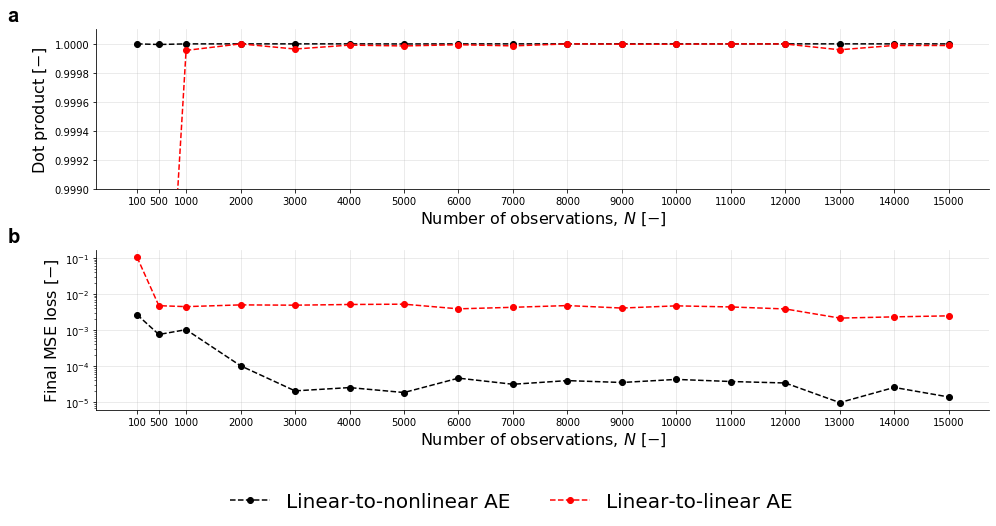

In [34]:
dot_product_tanh = pd.read_csv('../results/2D-synthetic-dataset-effect-of-N-phi-1-dot-product-tanh.csv', sep = ',', header=None).to_numpy()
dot_product_linear = pd.read_csv('../results/2D-synthetic-dataset-effect-of-N-phi-1-dot-product-linear.csv', sep = ',', header=None).to_numpy()
mse_tanh = pd.read_csv('../results/2D-synthetic-dataset-effect-of-N-phi-1-mse-tanh.csv', sep = ',', header=None).to_numpy()
mse_linear = pd.read_csv('../results/2D-synthetic-dataset-effect-of-N-phi-1-mse-linear.csv', sep = ',', header=None).to_numpy()

fig = plt.figure(figsize=(16, 7))
spec = fig.add_gridspec(ncols=1, nrows=3, width_ratios=[1], height_ratios=[1,0.1,1])

figure_a = fig.add_subplot(spec[0,0])
plt.plot(n_points_list, dot_product_tanh, 'ko--')
plt.plot(n_points_list, dot_product_linear, 'ro--')
plt.xlabel('Number of observations, $N$ [$-$]', fontsize=16)
plt.ylabel('Dot product [$-$]', fontsize=16)
plt.grid(alpha=0.3)
plt.xticks(n_points_list)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.ylim([0.999,1.0001])
plt.text(-0.1,1.05, 'a', fontsize=20, transform=figure_a.transAxes, **hfont)

figure_b = fig.add_subplot(spec[2,0])
plt.semilogy(n_points_list, mse_tanh, 'ko--', label='Linear-to-nonlinear AE')
plt.semilogy(n_points_list, mse_linear, 'ro--', label='Linear-to-linear AE')
plt.xlabel('Number of observations, $N$ [$-$]', fontsize=16)
plt.ylabel('Final MSE loss [$-$]', fontsize=16)
plt.grid(alpha=0.3)
plt.xticks(n_points_list)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.1,1.05, 'b', fontsize=20, transform=figure_b.transAxes, **hfont)
plt.legend(ncol=2, frameon=False, bbox_to_anchor=(0.8,-0.4), fontsize=20)

plt.savefig(plot_save_location + 'AE-effect-of-more-data-points-phi-1.pdf', dpi=300, bbox_inches='tight')

In [21]:
mse_tanh = []
mse_linear = []
dot_product_tanh = []
dot_product_linear = []

tic = time.perf_counter()

for n_points in n_points_list:
    
    print('Running for ' + str(n_points) + ' observations in the training data.')
    
    np.random.seed(seed=10)
    mean = [0,0]
    covariance = [[2, 0.52], [0.52, 0.2]]
    x_noise, y_noise = np.random.multivariate_normal(mean, covariance, n_points).T
    dataset_2D = np.column_stack((x_noise, y_noise))
    dataset_2D_normalized, centers_2D, scales_2D = preprocess.center_scale(dataset_2D, scaling='-1to1')

    phi_1 = np.sin((dataset_2D_normalized[:,0]+0.8))
    phi_2 = np.sin((dataset_2D_normalized[:,1]+0.8))
    phi_3 = np.sin(dataset_2D_normalized[:,0] * 8)
    phi_4 = np.exp(-((np.sqrt(dataset_2D_normalized[:,0]**2+dataset_2D_normalized[:,1]**2))**2 / (2.0 * 0.3**2)))

    phi_2D = np.column_stack((phi_1, phi_2, phi_3, phi_4))
    phi_2D_normalized, centers_phi, scales_phi = preprocess.center_scale(phi_2D, scaling='-1to1')
    
    _, _, _, _, _, basis_tanh, final_loss_tanh = autoencoder_linear_to_nonlinear(dataset_2D_normalized,
                                             phi_2D_normalized[:,1:2],
                                             n_dim=1,
                                             c=2,
                                             d=2,
                                             n_epochs=None,
                                             train_perc=80,
                                             learning_rate=0.001,
                                             batch_size=100)

    _, _, _, basis_linear, final_loss_linear = autoencoder_linear_to_linear(dataset_2D_normalized,
                                             phi_2D_normalized[:,1:2],
                                             n_dim=1,
                                             n_epochs=None,
                                             train_perc=80,
                                             learning_rate=0.001,
                                             batch_size=100)
    
    mse_tanh.append(final_loss_tanh)
    mse_linear.append(final_loss_linear)
    dot_product_tanh.append(np.abs(np.dot(basis_tanh.T, np.array([[0],[1]]))[0,0]))
    dot_product_linear.append(np.abs(np.dot(basis_linear.T, np.array([[0],[1]]))[0,0]))

np.savetxt('../results/2D-synthetic-dataset-effect-of-N-phi-2-dot-product-tanh.csv', (dot_product_tanh), delimiter=',', fmt='%.16e')
np.savetxt('../results/2D-synthetic-dataset-effect-of-N-phi-2-dot-product-linear.csv', (dot_product_linear), delimiter=',', fmt='%.16e')
np.savetxt('../results/2D-synthetic-dataset-effect-of-N-phi-2-mse-tanh.csv', (mse_tanh), delimiter=',', fmt='%.16e')
np.savetxt('../results/2D-synthetic-dataset-effect-of-N-phi-2-mse-linear.csv', (mse_linear), delimiter=',', fmt='%.16e')

toc = time.perf_counter()

print(f'Time it took for this run: {(toc - tic)/60:0.1f} minutes.\n' + '- '*22)

Running for 100 observations in the training data.
Running for 500 observations in the training data.
Running for 1000 observations in the training data.
Running for 2000 observations in the training data.
Running for 3000 observations in the training data.
Running for 4000 observations in the training data.
Running for 5000 observations in the training data.
Running for 6000 observations in the training data.
Running for 7000 observations in the training data.
Running for 8000 observations in the training data.
Running for 9000 observations in the training data.
Running for 10000 observations in the training data.
Running for 11000 observations in the training data.
Running for 12000 observations in the training data.
Running for 13000 observations in the training data.
Running for 14000 observations in the training data.
Running for 15000 observations in the training data.
Time it took for this run: 13.1 minutes.
- - - - - - - - - - - - - - - - - - - - - - 


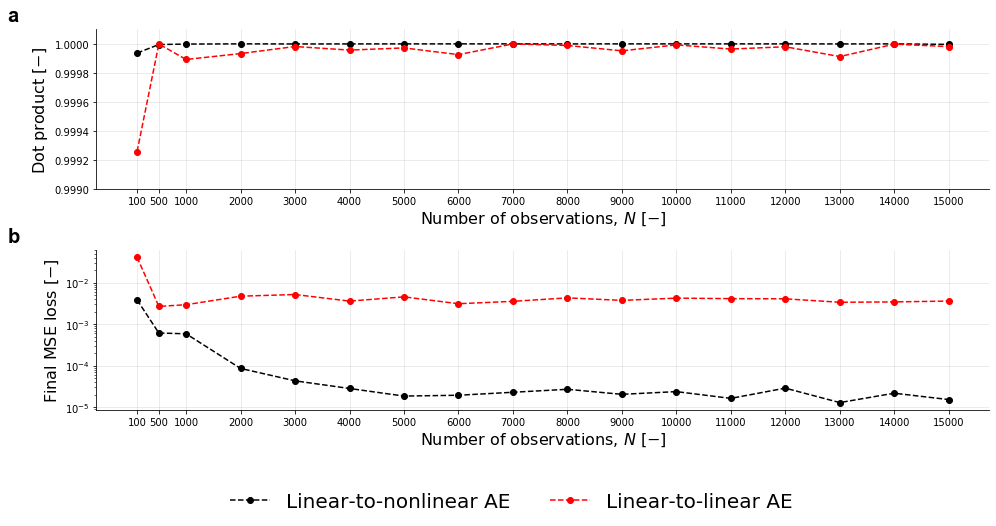

In [35]:
dot_product_tanh = pd.read_csv('../results/2D-synthetic-dataset-effect-of-N-phi-2-dot-product-tanh.csv', sep = ',', header=None).to_numpy()
dot_product_linear = pd.read_csv('../results/2D-synthetic-dataset-effect-of-N-phi-2-dot-product-linear.csv', sep = ',', header=None).to_numpy()
mse_tanh = pd.read_csv('../results/2D-synthetic-dataset-effect-of-N-phi-2-mse-tanh.csv', sep = ',', header=None).to_numpy()
mse_linear = pd.read_csv('../results/2D-synthetic-dataset-effect-of-N-phi-2-mse-linear.csv', sep = ',', header=None).to_numpy()

fig = plt.figure(figsize=(16, 7))
spec = fig.add_gridspec(ncols=1, nrows=3, width_ratios=[1], height_ratios=[1,0.1,1])

figure_a = fig.add_subplot(spec[0,0])
plt.plot(n_points_list, dot_product_tanh, 'ko--')
plt.plot(n_points_list, dot_product_linear, 'ro--')
plt.xlabel('Number of observations, $N$ [$-$]', fontsize=16)
plt.ylabel('Dot product [$-$]', fontsize=16)
plt.grid(alpha=0.3)
plt.xticks(n_points_list)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.ylim([0.999,1.0001])
plt.text(-0.1,1.05, 'a', fontsize=20, transform=figure_a.transAxes, **hfont)

figure_b = fig.add_subplot(spec[2,0])
plt.semilogy(n_points_list, mse_tanh, 'ko--', label='Linear-to-nonlinear AE')
plt.semilogy(n_points_list, mse_linear, 'ro--', label='Linear-to-linear AE')
plt.xlabel('Number of observations, $N$ [$-$]', fontsize=16)
plt.ylabel('Final MSE loss [$-$]', fontsize=16)
plt.grid(alpha=0.3)
plt.xticks(n_points_list)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.text(-0.1,1.05, 'b', fontsize=20, transform=figure_b.transAxes, **hfont)
plt.legend(ncol=2, frameon=False, bbox_to_anchor=(0.8,-0.4), fontsize=20)

plt.savefig(plot_save_location + 'AE-effect-of-more-data-points-phi-2.pdf', dpi=300, bbox_inches='tight')

***